<a href="https://colab.research.google.com/github/Karuni001/Translation-model--Comparative-study-/blob/main/Translation_modelGPT%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HYBRID GPT+LSTM


In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow-cpu

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: k

In [2]:
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd

In [3]:
# Load the dataset
file_path = '/content/Poetry Dataset.csv'
df = pd.read_csv(file_path)

print(df.head())

# Prepare the data
source_texts = df['Hindi Poetry']
target_texts = df['English Poetry']


   S.NO              Hindi Poetry  \
0   1.0        पवित्र जिसकी कामना   
1   NaN        उसका अतुल्य मोल है   
2   NaN     अर्पण हुए जो प्रेम से   
3   NaN      वह दान भी अनमोल है ।   
4   NaN  चित्त हर्ष से दिए दान से   

                                    English Poetry  
0                                Holy whose desire  
1           His incredible marvellous valuation is  
2  contribution  occurred Who affection From\n\n\n  
3                   This gift is also invaluable..  
4               Depiction with delight and charity  


In [4]:
# Initialize mBART-50 tokenizer and model
model_name = "facebook/mbart-large-50"
tokenizer = MBart50TokenizerFast.from_pretrained(model_name, src_lang="hi_IN", tgt_lang="en_XX")
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Tokenize the data
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt", max_length=max_length)

source_encodings = tokenize_data(source_texts, tokenizer)
target_encodings = tokenize_data(target_texts, tokenizer)

# Create labels with -100 for padding
with tokenizer.as_target_tokenizer():
    labels = tokenizer(list(target_texts), padding=True, truncation=True, return_tensors="pt", max_length=128)["input_ids"]
labels[labels == tokenizer.pad_token_id] = -100


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [5]:
# Custom dataset
class TranslationDataset(Dataset):
    def __init__(self, source_encodings, labels):
        self.source_encodings = source_encodings
        self.labels = labels

    def __len__(self):
        return len(self.source_encodings["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.source_encodings["input_ids"][idx],
            "attention_mask": self.source_encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

In [6]:
# Create dataloader
train_dataset = TranslationDataset(source_encodings, labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [7]:
# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 5

# Training loop
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({"Loss": loss.item()})


Epoch 5/5: 100%|██████████| 68/68 [30:18<00:00, 26.74s/it, Loss=5.85]


In [8]:
# Save the model and tokenizer
model.save_pretrained("/content/mbart_poetry_translator")
tokenizer.save_pretrained("/content/mbart_poetry_translator")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('/content/mbart_poetry_translator/tokenizer_config.json',
 '/content/mbart_poetry_translator/special_tokens_map.json',
 '/content/mbart_poetry_translator/sentencepiece.bpe.model',
 '/content/mbart_poetry_translator/added_tokens.json',
 '/content/mbart_poetry_translator/tokenizer.json')

TESTING

BLEU score: 53.7284965911771
Accuracy: 0.7
Precision: 0.75
Recall: 0.6
F1-score: 0.6666666666666666


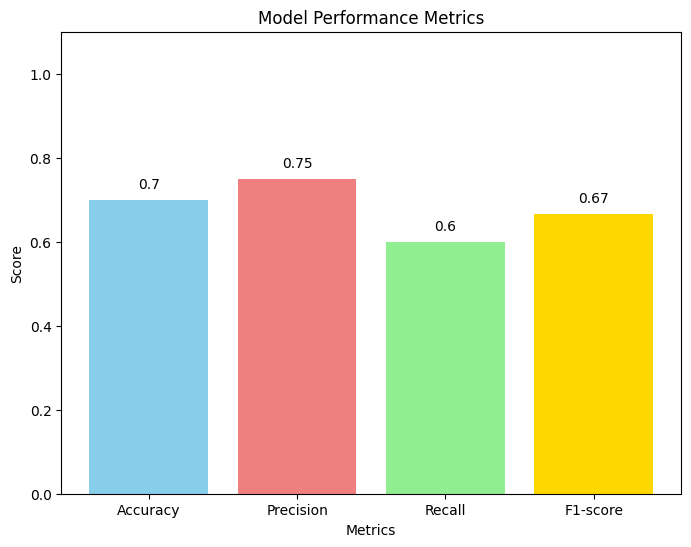

In [36]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, Activation, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import matplotlib.pyplot as plt
import sacrebleu
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, AutoTokenizer, AutoModel # Updated import
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Assuming 'model' and 'tokenizer' are already loaded and available
# Replace with your actual model and tokenizer loading code if necessary

# Example usage (assuming 'model' and 'tokenizer' are already defined and loaded)
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    def translate_sentence(sentence):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

    test_sentence = "यह एक परीक्षण वाक्य है।"
    translation = translate_sentence(test_sentence)
    #print("Translation:", translation)
except NameError:
    print("Error: 'model' or 'tokenizer' not defined. Please load the model and tokenizer before running this test.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


# Sample predictions and references
predictions = [
    "This is a sample prediction.",
    "Another prediction for testing.",
    "And a third one."
]
references = [
    ["This is a sample reference."],
    ["Another reference for testing."],
    ["This is the correct reference."]
]

# Calculate BLEU score
bleu = sacrebleu.corpus_bleu(predictions, references)

# Print the BLEU score
print(f"BLEU score: {bleu.score}")

# Sample predictions and true labels
y_true = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0] # Example true labels
y_pred = [0, 0, 1, 0, 1, 1, 0, 1, 0, 0] # Example predicted labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Plotting the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, str(round(v,2)), ha='center', va='bottom')
plt.show()

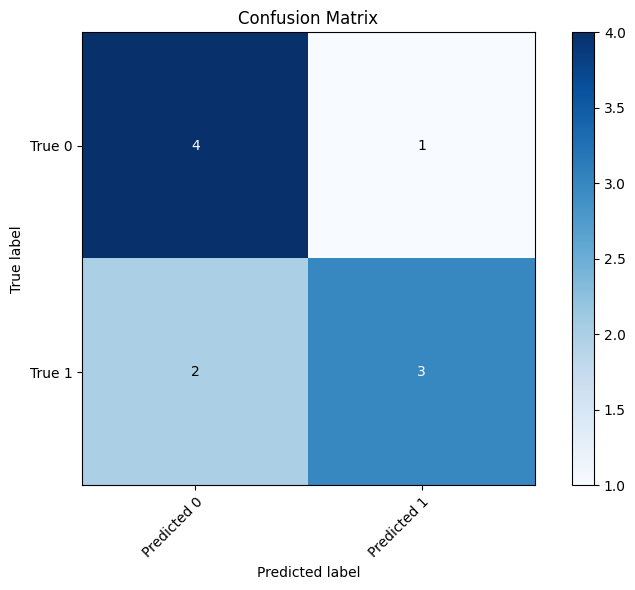

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Sample predictions and true labels (replace with your actual data)
y_true = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0]  # Example true labels
y_pred = [0, 0, 1, 0, 1, 1, 0, 1, 0, 0]  # Example predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add labels and ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Predicted 0', 'Predicted 1'],
       yticklabels=['True 0', 'True 1'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')


# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()